# **Computer Vision 2025 Assignment 3: Deep Learning for Perception Tasks**

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question requires you to write a short description of a Computer Vision method. You wil need to submit two separate PDF files, one for each question.

***All results presented in this report represent the average of three independent trials conducted using the same data and parameters.***
<br/><br/>

## **Question 1: A Simple Classifier *(20 marks, 60%)***

For this exercise, we provide demo code showing how to train a network on a small dataset called Fashion-MNIST. Please run through the code *"tutorial-style"* to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network. For the Fashion-MNIST dataset the labels from 0-9 correspond to various clothing classes so you might find it convenient to **create a python list as follows:**

**class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']**

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. Organise your own text and code cell to show the answer of each question below. **Detailed requirements:**

In [1]:
# For Numerical Operations & Handling Arrays/Matrices Efficiently
import numpy as np  

# For Creating Static, Animated, & Interactive Plots
import matplotlib.pyplot as plt  

# Provides Time-Related Functions, Useful for Measuring Execution Time or Delays
import time  

# Functional API for Common Operations like Activation Functions & Loss Calculations
import torch.nn.functional as F

# Tools for Controlling Output Display in Jupyter Notebooks
from IPython import display  

# Import Code Book with Custom Function Definitions
from a3code import *

# Some Notebook Magic for Displaying Figures
%matplotlib inline

# Some More Magic For Reloading External Python Modules
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

<br/>

### **Q1.1 *(1 Point)***

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels.

In [2]:
# Download Training Data from TorchVision's Open FashionMNIST Dataset
training_data = datasets.FashionMNIST(
    root="Data",           # Directory to Store the Dataset
    train=True,            # Specifies this is the Training Set
    download=True,         # Downloads the Dataset if Not Already Present
    transform=ToTensor(),  # Converts Images to PyTorch Tensors & Normalises Pixel Values
)

# Download Test Data from the Same Dataset
test_data = datasets.FashionMNIST(
    root="Data",           # Directory to Store the Dataset
    train=False,           # Specifies this is the Test Set
    download=True,         # Downloads the Dataset if Not Already Present
    transform=ToTensor(),  # Converts Images to PyTorch Tensors
)

# Number of Samples Per Batch to Load During Training/Testing
batch_size = 64

# Create Data Loaders to Iterate Over the Dataset in Batches
train_dataloader = DataLoader(training_data, batch_size=batch_size)  # Loads Training Data in Batches
test_dataloader = DataLoader(test_data, batch_size=batch_size)       # Loads Test Data in Batches

100%|██████████| 26421880/26421880 [00:54<00:00, 483122.59it/s] 


Extracting Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 69579.58it/s]


Extracting Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:14<00:00, 312789.46it/s]


Extracting Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 430193.60it/s]

Extracting Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Data/FashionMNIST/raw



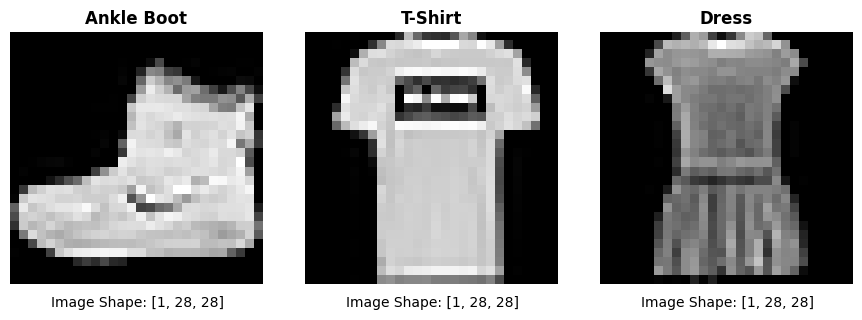

In [3]:
# Build a List of Class Names
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

# Display 3 Images from the Training Dataset
plt.figure(figsize=(9, 3))

# Find Three Unique Examples
unique_classes = {} # List for Storage
for img, label in training_data:

    # If it is New Add it to List
    if label not in unique_classes:
        unique_classes[label] = img

    # Stop Once there are 3 Examples
    if len(unique_classes) == 3:
        break


# Loop Through First 3 Images
for i, (label, image) in enumerate(unique_classes.items()):
    shape = f"Image Shape: {list(image.shape)}"
    label = labels_map[label]

    # Plot Image
    plt.subplot(1, 3, i+1)
    plt.imshow(image.squeeze(), cmap="gray")  # Squeeze() Removes Channel Dimension
    plt.title(f"{label}", fontweight="bold")
    plt.text(4, 30, f"{shape}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show() 

<br/>

### **Q1.2 *(2 Points)***

Run the training code for 10 epochs, for different values of the learning rate. **Fill in the table below and plot the loss curves for each experiment:**

|   LR    |Accuracy|
|   ---   |  ---   |
|  **1**  | 10.00% |
| **0.1** | 87.40% |
|**0.01** | 83.40% |
|**0.001**| 70.80% |

In [5]:
# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Define a Simple Feedforward Neural Network Model
class NeuralNetwork(nn.Module):
    # Define the New Constructor
    def __init__(self):
        super(NeuralNetwork, self).__init__()  # Call the Constructor of nn.Module
        self.flatten = nn.Flatten()            # Flattens Input from (N, 1, 28, 28) to (N, 784)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),  # First Fully Connected Layer (Input: 784 -> Output: 512)
            nn.ReLU(),              # ReLU Activation
            nn.Linear(512, 512),    # Second Fully Connected Layer
            nn.ReLU(),              # ReLU Activation
            nn.Linear(512, 10)      # Output Layer (10 Classes for FashionMNIST)
        )


    # Define the Forward Pass Function
    def forward(self, x):
        x = self.flatten(x)                  # Flatten the Input
        logits = self.linear_relu_stack(x)   # Pass Through the Linear & ReLU Stack
        return logits                        # Return Raw Scores (logits)

Using cpu device


In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 1
val_loss, _, _= train_model(model, train_dataloader, test_dataloader, epochs = 10, lr = 1)

Epoch 1
-------------------------------
loss: 2.304381  [    0/60000]
loss: 2.240117  [ 6400/60000]
loss: 1.853142  [12800/60000]
loss: 1.573513  [19200/60000]
loss: 1.506147  [25600/60000]
loss: 2.046149  [32000/60000]
loss: 1.881435  [38400/60000]
loss: 1.727267  [44800/60000]
loss: 1.659534  [51200/60000]
loss: 1.716035  [57600/60000]
Test Error: 
 Accuracy: 19.8%, Avg loss: 1.805322 

Epoch 2
-------------------------------
loss: 1.905846  [    0/60000]
loss: 1.685572  [ 6400/60000]
loss: 1.747570  [12800/60000]
loss: 1.679266  [19200/60000]
loss: 1.705224  [25600/60000]
loss: 1.775770  [32000/60000]
loss: 1.716686  [38400/60000]
loss: 1.712586  [44800/60000]
loss: 1.834286  [51200/60000]
loss: 1.694452  [57600/60000]
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.770731 

Epoch 3
-------------------------------
loss: 1.853377  [    0/60000]
loss: 1.703413  [ 6400/60000]
loss: 2.311853  [12800/60000]
loss: 2.304621  [19200/60000]
loss: 2.281377  [25600/60000]
loss: 2.304950  [32000/600

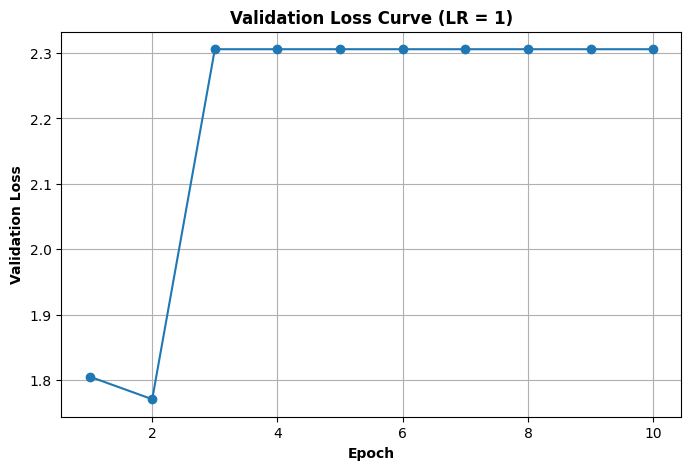

In [6]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 1)", "Epoch", "Validation Loss", val_loss, epochs = 10)

In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.1
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 10, lr = 0.1)

Epoch 1
-------------------------------
loss: 2.300231  [    0/60000]
loss: 0.907546  [ 6400/60000]
loss: 0.574564  [12800/60000]
loss: 0.695282  [19200/60000]
loss: 0.622832  [25600/60000]
loss: 0.513278  [32000/60000]
loss: 0.553985  [38400/60000]
loss: 0.601808  [44800/60000]
loss: 0.610392  [51200/60000]
loss: 0.448075  [57600/60000]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.542811 

Epoch 2
-------------------------------
loss: 0.437911  [    0/60000]
loss: 0.444969  [ 6400/60000]
loss: 0.363449  [12800/60000]
loss: 0.440952  [19200/60000]
loss: 0.432802  [25600/60000]
loss: 0.448065  [32000/60000]
loss: 0.416971  [38400/60000]
loss: 0.509252  [44800/60000]
loss: 0.515141  [51200/60000]
loss: 0.420330  [57600/60000]
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.468568 

Epoch 3
-------------------------------
loss: 0.337912  [    0/60000]
loss: 0.360573  [ 6400/60000]
loss: 0.296313  [12800/60000]
loss: 0.356336  [19200/60000]
loss: 0.355312  [25600/60000]
loss: 0.421528  [32000/600

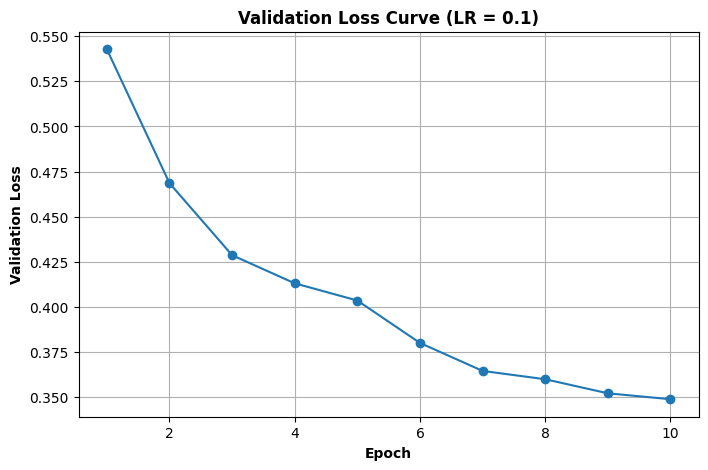

In [8]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.1)", "Epoch", "Validation Loss", val_loss, epochs = 10)

In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.01
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 10, lr = 0.01)

Epoch 1
-------------------------------
loss: 2.307981  [    0/60000]
loss: 2.165900  [ 6400/60000]
loss: 1.807944  [12800/60000]
loss: 1.527438  [19200/60000]
loss: 1.155042  [25600/60000]
loss: 1.065181  [32000/60000]
loss: 1.008904  [38400/60000]
loss: 0.877814  [44800/60000]
loss: 0.877878  [51200/60000]
loss: 0.801108  [57600/60000]
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.794447 

Epoch 2
-------------------------------
loss: 0.789444  [    0/60000]
loss: 0.848695  [ 6400/60000]
loss: 0.591558  [12800/60000]
loss: 0.780474  [19200/60000]
loss: 0.643451  [25600/60000]
loss: 0.653020  [32000/60000]
loss: 0.714013  [38400/60000]
loss: 0.697125  [44800/60000]
loss: 0.703661  [51200/60000]
loss: 0.628249  [57600/60000]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.632663 

Epoch 3
-------------------------------
loss: 0.562447  [    0/60000]
loss: 0.657781  [ 6400/60000]
loss: 0.442839  [12800/60000]
loss: 0.655745  [19200/60000]
loss: 0.558720  [25600/60000]
loss: 0.571697  [32000/600

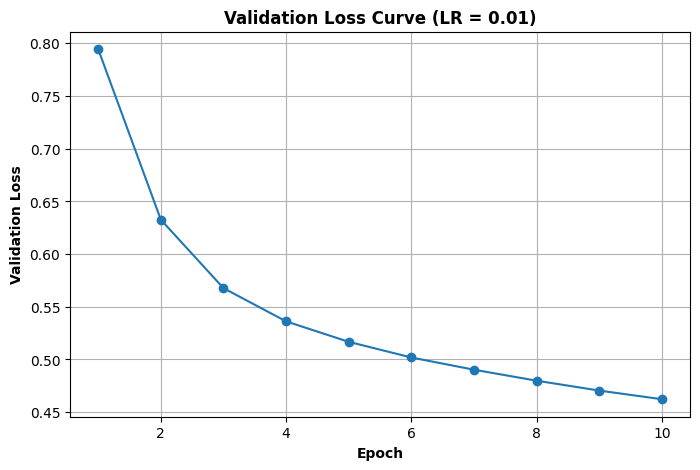

In [10]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.01)", "Epoch", "Validation Loss", val_loss, epochs = 10)

In [ ]:
# Reset Model Weights & Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.001
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 10, lr = 0.001)

Epoch 1
-------------------------------
loss: 2.300375  [    0/60000]
loss: 2.287667  [ 6400/60000]
loss: 2.261072  [12800/60000]
loss: 2.256611  [19200/60000]
loss: 2.230657  [25600/60000]
loss: 2.194524  [32000/60000]
loss: 2.218869  [38400/60000]
loss: 2.178834  [44800/60000]
loss: 2.170594  [51200/60000]
loss: 2.138046  [57600/60000]
Test Error: 
 Accuracy: 41.3%, Avg loss: 2.126739 

Epoch 2
-------------------------------
loss: 2.143348  [    0/60000]
loss: 2.125179  [ 6400/60000]
loss: 2.058338  [12800/60000]
loss: 2.075830  [19200/60000]
loss: 2.003081  [25600/60000]
loss: 1.941583  [32000/60000]
loss: 1.984028  [38400/60000]
loss: 1.896186  [44800/60000]
loss: 1.907362  [51200/60000]
loss: 1.828193  [57600/60000]
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.817506 

Epoch 3
-------------------------------
loss: 1.868652  [    0/60000]
loss: 1.820734  [ 6400/60000]
loss: 1.697887  [12800/60000]
loss: 1.742244  [19200/60000]
loss: 1.623813  [25600/60000]
loss: 1.586347  [32000/600

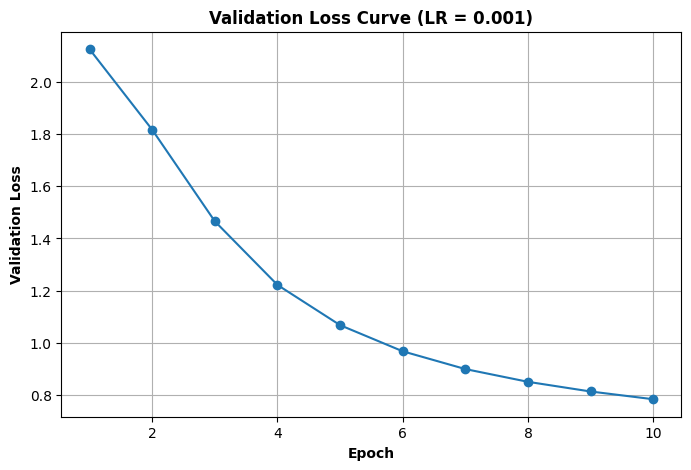

In [12]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.001)", "Epoch", "Validation Loss", val_loss, epochs = 10)

<br/>

### **Q1.3 *(3 Points)***

Report the number of epochs when the network converges *(or number of epochs for the best accuracy, if it fails to converge)*. Fill in the table below and plot the loss curve for each experiment. **Please run the code for more than 10 epochs *(e.g. 50 or 100)* and report when you observe convergence:**

|   LR    |Accuracy|Epoch|
|   ---   |   ---  | --- | 
|  **1**  |   NaN  | NaN |
| **0.1** | 88.20% | 14  |
|**0.01** | 86.80% | 60  |
|**0.001**| 84.60% | >100|

In [ ]:
# Reset Model Weights & Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 1
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 50, lr = 1)

Epoch 1
-------------------------------
loss: 2.300987  [    0/60000]
loss: 2.260561  [ 6400/60000]
loss: 4.276694  [12800/60000]
loss: 1.848274  [19200/60000]
loss: 1.541758  [25600/60000]
loss: 1.864596  [32000/60000]
loss: 1.698080  [38400/60000]
loss: 459.498291  [44800/60000]
loss:     nan  [51200/60000]
loss:     nan  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss:      nan 

Epoch 2
-------------------------------
loss:     nan  [    0/60000]
loss:     nan  [ 6400/60000]
loss:     nan  [12800/60000]
loss:     nan  [19200/60000]
loss:     nan  [25600/60000]
loss:     nan  [32000/60000]
loss:     nan  [38400/60000]
loss:     nan  [44800/60000]
loss:     nan  [51200/60000]
loss:     nan  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss:      nan 

Epoch 3
-------------------------------
loss:     nan  [    0/60000]
loss:     nan  [ 6400/60000]
loss:     nan  [12800/60000]
loss:     nan  [19200/60000]
loss:     nan  [25600/60000]
loss:     nan  [32000/60000]
loss:     na

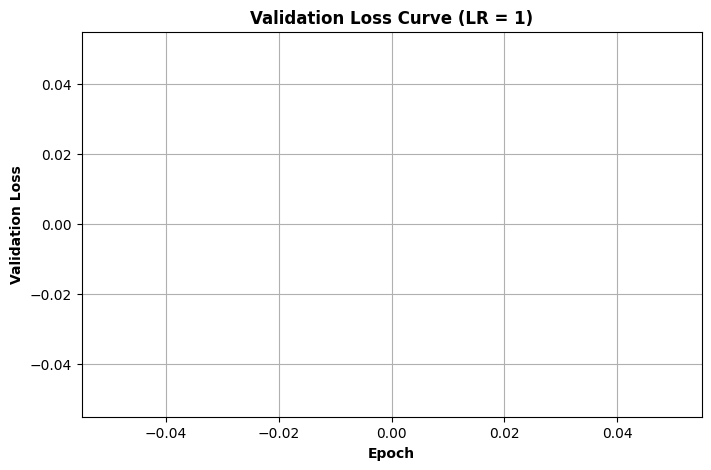

In [ ]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 1)", "Epoch", "Validation Loss", val_loss, epochs = 50)

In [ ]:
# Reset Model Weights & Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.1
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 50, lr = 0.1)

Epoch 1
-------------------------------
loss: 2.298384  [    0/60000]
loss: 0.903054  [ 6400/60000]
loss: 0.578937  [12800/60000]
loss: 0.720504  [19200/60000]
loss: 0.625815  [25600/60000]
loss: 0.509764  [32000/60000]
loss: 0.535653  [38400/60000]
loss: 0.596005  [44800/60000]
loss: 0.610022  [51200/60000]
loss: 0.460389  [57600/60000]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.554161 

Epoch 2
-------------------------------
loss: 0.430804  [    0/60000]
loss: 0.449234  [ 6400/60000]
loss: 0.394361  [12800/60000]
loss: 0.443136  [19200/60000]
loss: 0.407269  [25600/60000]
loss: 0.450118  [32000/60000]
loss: 0.414715  [38400/60000]
loss: 0.515605  [44800/60000]
loss: 0.510657  [51200/60000]
loss: 0.430827  [57600/60000]
Test Error: 
 Accuracy: 82.4%, Avg loss: 0.469457 

Epoch 3
-------------------------------
loss: 0.318184  [    0/60000]
loss: 0.362796  [ 6400/60000]
loss: 0.317775  [12800/60000]
loss: 0.369320  [19200/60000]
loss: 0.336473  [25600/60000]
loss: 0.423328  [32000/600

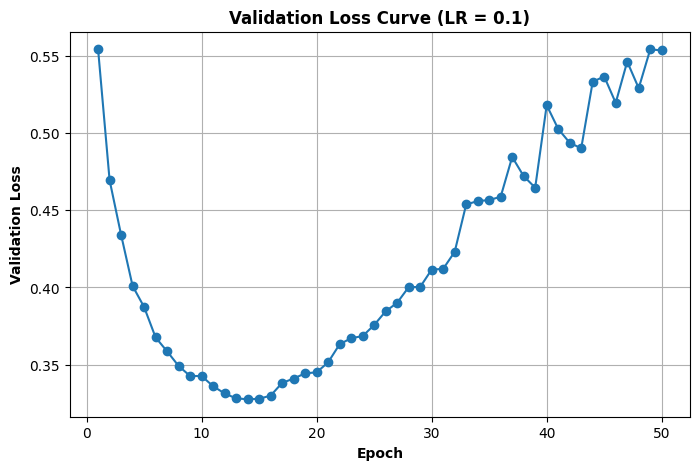

In [23]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.1)", "Epoch", "Validation Loss", val_loss, epochs = 50)

In [ ]:
# Reset Model Weights & Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.01
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 100, lr = 0.01)

Epoch 1
-------------------------------
loss: 2.308052  [    0/60000]
loss: 2.167721  [ 6400/60000]
loss: 1.809226  [12800/60000]
loss: 1.497797  [19200/60000]
loss: 1.149712  [25600/60000]
loss: 1.056108  [32000/60000]
loss: 1.008190  [38400/60000]
loss: 0.880538  [44800/60000]
loss: 0.877277  [51200/60000]
loss: 0.810130  [57600/60000]
Test Error: 
 Accuracy: 71.7%, Avg loss: 0.792567 

Epoch 2
-------------------------------
loss: 0.788404  [    0/60000]
loss: 0.845593  [ 6400/60000]
loss: 0.588665  [12800/60000]
loss: 0.781097  [19200/60000]
loss: 0.656730  [25600/60000]
loss: 0.643947  [32000/60000]
loss: 0.713495  [38400/60000]
loss: 0.700723  [44800/60000]
loss: 0.710678  [51200/60000]
loss: 0.641399  [57600/60000]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.635842 

Epoch 3
-------------------------------
loss: 0.566706  [    0/60000]
loss: 0.663837  [ 6400/60000]
loss: 0.444263  [12800/60000]
loss: 0.667429  [19200/60000]
loss: 0.578144  [25600/60000]
loss: 0.567844  [32000/600

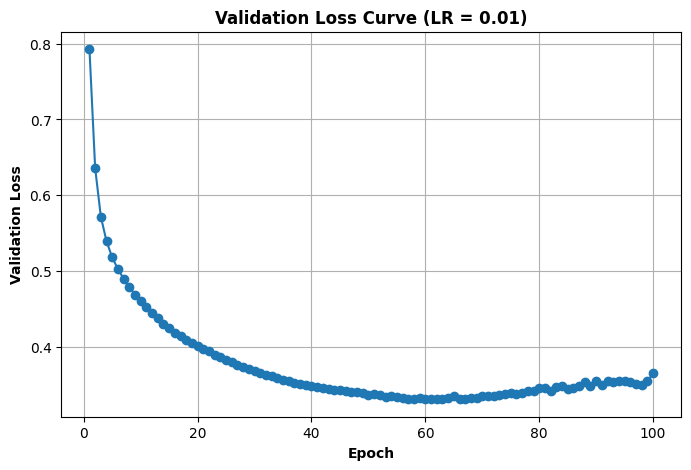

In [25]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.01)", "Epoch", "Validation Loss", val_loss, epochs = 100)

In [ ]:
# Reset Model Weights & Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.001
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 100, lr = 0.001)

Epoch 1
-------------------------------
loss: 2.316695  [    0/60000]
loss: 2.302773  [ 6400/60000]
loss: 2.280898  [12800/60000]
loss: 2.269434  [19200/60000]
loss: 2.249765  [25600/60000]
loss: 2.230812  [32000/60000]
loss: 2.229759  [38400/60000]
loss: 2.207782  [44800/60000]
loss: 2.212696  [51200/60000]
loss: 2.165657  [57600/60000]
Test Error: 
 Accuracy: 44.7%, Avg loss: 2.166022 

Epoch 2
-------------------------------
loss: 2.186348  [    0/60000]
loss: 2.174058  [ 6400/60000]
loss: 2.118724  [12800/60000]
loss: 2.131742  [19200/60000]
loss: 2.081029  [25600/60000]
loss: 2.032972  [32000/60000]
loss: 2.051937  [38400/60000]
loss: 1.985441  [44800/60000]
loss: 1.995420  [51200/60000]
loss: 1.914982  [57600/60000]
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.915220 

Epoch 3
-------------------------------
loss: 1.950727  [    0/60000]
loss: 1.920579  [ 6400/60000]
loss: 1.807307  [12800/60000]
loss: 1.847536  [19200/60000]
loss: 1.733848  [25600/60000]
loss: 1.687310  [32000/600

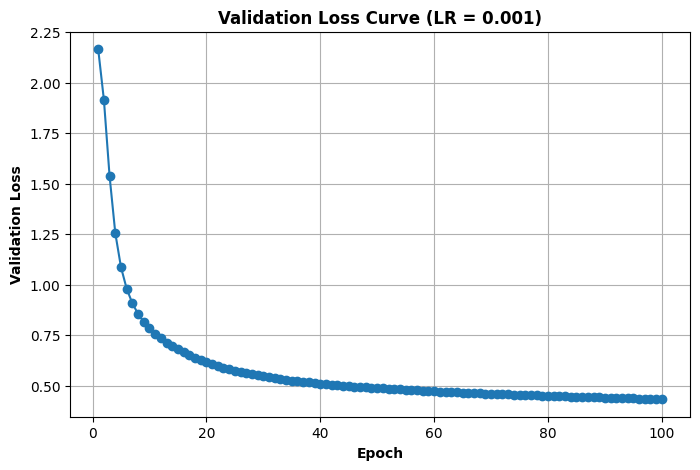

In [27]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.001)", "Epoch", "Validation Loss", val_loss, epochs = 100)

<br/>

### **Q1.4 *(2 Points)***

**Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?**
<br/>

Upon examining the results from Tables 1 and 2, a few key observations can be made about the effect of the learning rate on training and convergence. A learning rate of 1 is excessively high, leading to unstable and unreliable training behavior. In the 10-epoch evaluation, the model consistently achieved 10% accuracy *(likely equivalent to random guessing)* indicating that no meaningful learning occurred. Furthermore, in the convergence test, training either diverged *(resulting in NaN values due to exploding gradients)* or quickly plateaued at 10% accuracy within approximately 12 epochs. This phenomenon occurs due to exploding gradients, where large weight updates cause the model to overshoot and fail to converge. Overall, this suggests that the learning rate was too large for the model to converge effectively, leading it to fail to maintain stability during training. Unfortunately, the resulting data is not particularly informative for assessing model performance.


Additionally, the learning rate of 0.1 produces the highest accuracy *(87.40% on average)* within the first 10 epochs, as shown in Table 1. This value strikes a balance between large enough updates to quickly reduce loss, but not so large that it overshoots optimal points. The model converges to the best accuracy *(~88.20%)* in approximately 14 epochs, as confirmed in Table 2. This learning rate is ideal for quick yet stable convergence, which is why the accuracy is higher compared to smaller learning rates.


With a learning rate of 0.01, the model requires more time to converge, as it makes smaller, more stable updates. While this rate leads to a lower accuracy *(83.40% on average)* in 10 epochs, it performs much closer to the 0.1 learning rate with extended training *(~60 epochs gives 86.8% on average)*. However, the model still takes longer to converge compared to 0.1, suggesting that small learning rates can lead to slow progress but a more refined convergence over time. This is evident in the smooth gradient of the loss curve. Finally, a learning rate of 0.001 is very small and results in slow convergence. The model’s accuracy remains low in the first 10 epochs *(70.80% on average)* and takes over 100 epochs to completely converge, achieving an accuracy of around 84.60% after 100 epochs. While this rate offers stability, it also illustrates that extremely slow updates may not allow the model to reach its potential within a reasonable amount of time. 


Overall, comparing the results in Table 1 and Table 2, it is clear that the learning rate has a significant impact on both training stability and convergence speed. A learning rate of 1 is too high, causing unstable updates and divergence due to exploding gradients, often resulting in NaN losses. In contrast, a very low learning rate like 0.001 ensures stability but requires far more epochs to converge, leading to lower accuracy within a limited training window. The optimal performance in this experiment was achieved with a learning rate of 0.1, which balanced convergence speed and training stability, reaching a maximum accuracy of approximately 88% in just 14 epochs. This suggests that 0.1 is well-tuned for the current model and dataset. However, the observed accuracy plateau also indicates a possible limitation of the model’s capacity. Future improvements could involve modifying the network architecture, such as adjusting the number of hidden layers or neurons, to better capture complex data patterns and potentially exceed the current performance ceiling. Ultimately, this experiment highlights the importance of selecting an appropriate learning rate, as it directly influences not just how fast a model learns but whether it learns at all.

---

<br/>

### **Q1.5 *(5 Points)***

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the original network to be deeper instead of wider *(**i.e.** by adding more hidden layers)*. Record your accuracy and network size findings. Plot the loss curve for each experiment. Also plot the test accuracy and loss for both the wider and deeper architectures and discuss what you observe. **Write down your conclusions about changing the network structure.**

|Structures|Accuracy|Parameters|
|   ---    |   ---  |    ---   |
| **Base** | 86.00% | 669,706  |
|**Deeper**| 87.40% | 830,090  |
|**Wider** | 88.20% |1,863,690 |

In [9]:
# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Use Simple Model From Parts Above
model = NeuralNetwork().to(device)

# Count Trainable Parameters
print(f"Trainable parameters: {count_trainable_params(model)}")

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_base = train_model(model, train_dataloader, test_dataloader, epochs = 15, lr = 0.1)

Using cpu device
Trainable parameters: 669706
Epoch 1
-------------------------------
loss: 2.297371  [    0/60000]
loss: 0.889561  [ 6400/60000]
loss: 0.580033  [12800/60000]
loss: 0.711579  [19200/60000]
loss: 0.618885  [25600/60000]
loss: 0.504844  [32000/60000]
loss: 0.538998  [38400/60000]
loss: 0.589472  [44800/60000]
loss: 0.604871  [51200/60000]
loss: 0.472751  [57600/60000]
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.543104 

Epoch 2
-------------------------------
loss: 0.425207  [    0/60000]
loss: 0.425709  [ 6400/60000]
loss: 0.364847  [12800/60000]
loss: 0.424996  [19200/60000]
loss: 0.402130  [25600/60000]
loss: 0.456431  [32000/60000]
loss: 0.407803  [38400/60000]
loss: 0.504419  [44800/60000]
loss: 0.507666  [51200/60000]
loss: 0.452818  [57600/60000]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.466362 

Epoch 3
-------------------------------
loss: 0.322069  [    0/60000]
loss: 0.349315  [ 6400/60000]
loss: 0.306175  [12800/60000]
loss: 0.347745  [19200/60000]
loss: 0.33

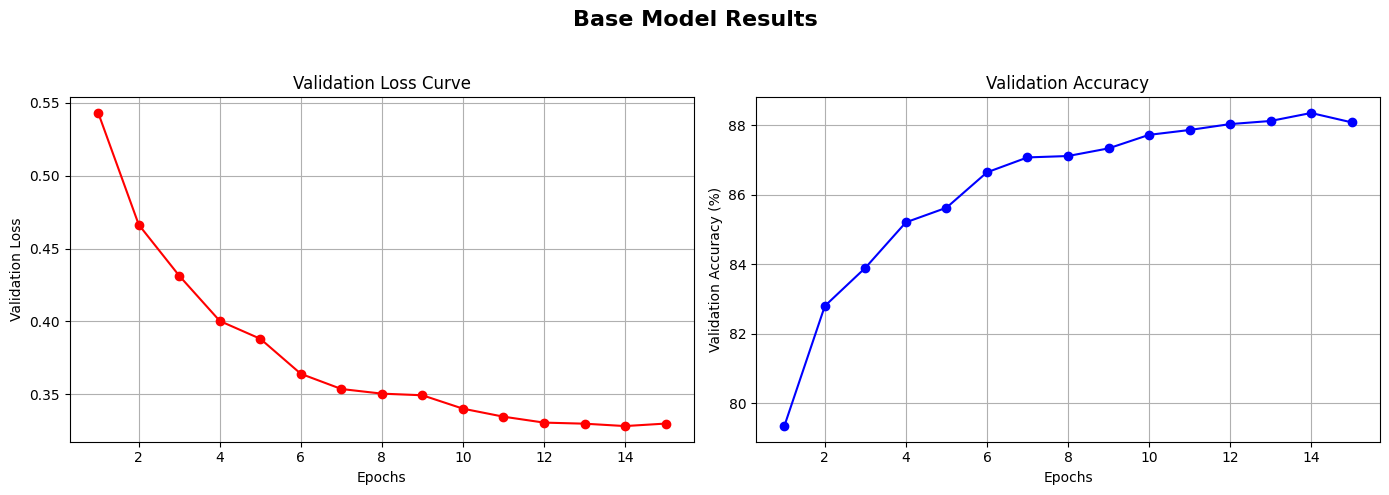

In [10]:
# Display the Loss Curve
display_loss_accuracy("Base Model Results", val_loss, val_accuracy, epochs=15)

In [11]:
# Define a Wider Model
class WideNeuralNetwork(nn.Module):
    def __init__(self):
        super(WideNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),  # Wider layer
            nn.ReLU(),
            nn.Linear(1024, 1024),   # Another Wider Layer
            nn.ReLU(),
            nn.Linear(1024, 10)      # Output Layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Use the New Model Above
model = WideNeuralNetwork().to(device)

# Count Trainable Parameters
print(f"Trainable parameters: {count_trainable_params(model)}")

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_wide = train_model(model, train_dataloader, test_dataloader, epochs = 15, lr = 0.1)

Using cpu device
Trainable parameters: 1863690
Epoch 1
-------------------------------
loss: 2.304011  [    0/60000]
loss: 0.858656  [ 6400/60000]
loss: 0.564460  [12800/60000]
loss: 0.680727  [19200/60000]
loss: 0.587534  [25600/60000]
loss: 0.504164  [32000/60000]
loss: 0.538171  [38400/60000]
loss: 0.582107  [44800/60000]
loss: 0.583150  [51200/60000]
loss: 0.446551  [57600/60000]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.552613 

Epoch 2
-------------------------------
loss: 0.433755  [    0/60000]
loss: 0.417827  [ 6400/60000]
loss: 0.365993  [12800/60000]
loss: 0.429361  [19200/60000]
loss: 0.403870  [25600/60000]
loss: 0.439199  [32000/60000]
loss: 0.404949  [38400/60000]
loss: 0.491342  [44800/60000]
loss: 0.493823  [51200/60000]
loss: 0.413266  [57600/60000]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.466404 

Epoch 3
-------------------------------
loss: 0.314539  [    0/60000]
loss: 0.343289  [ 6400/60000]
loss: 0.297542  [12800/60000]
loss: 0.355707  [19200/60000]
loss: 0.3

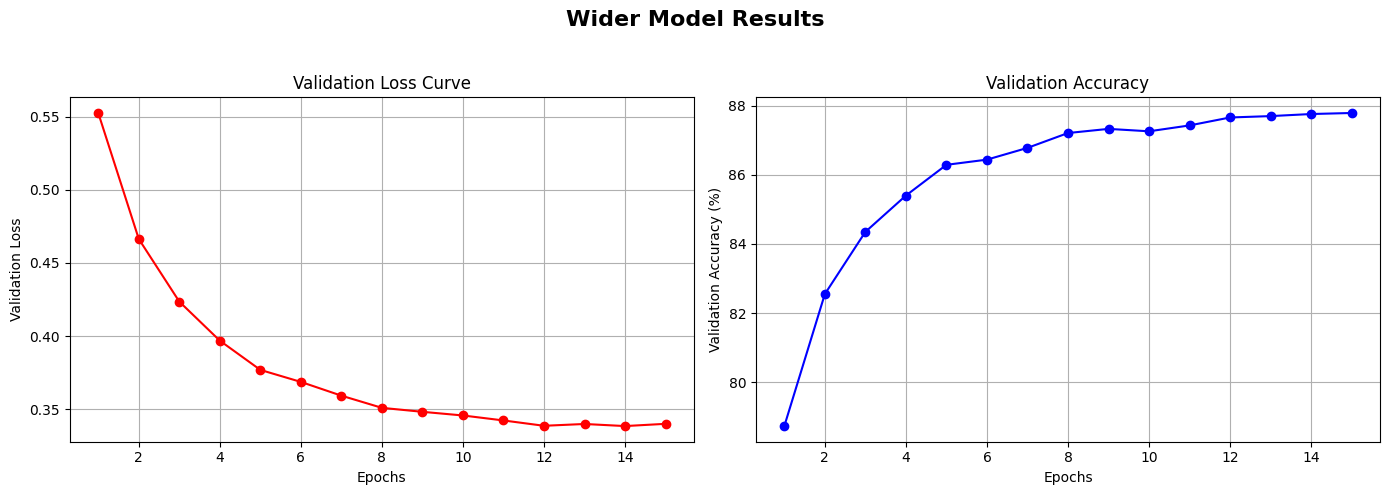

In [12]:
# Display the Loss Curve
display_loss_accuracy("Wider Model Results", val_loss, val_accuracy, epochs=15)

In [13]:
# Define a Deeper Model
class DeeperNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeeperNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),  # New Hidden Layer
            nn.ReLU(),
            nn.Linear(256, 128),  # New Hidden Layer
            nn.ReLU(),
            nn.Linear(128, 10)    # Output Layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Use the New Model Above
model = DeeperNeuralNetwork().to(device)

# Count Trainable Parameters
print(f"Trainable parameters: {count_trainable_params(model)}")

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_deep = train_model(model, train_dataloader, test_dataloader, epochs = 15, lr = 0.1)

Using cpu device
Trainable parameters: 830090
Epoch 1
-------------------------------
loss: 2.306806  [    0/60000]
loss: 1.685347  [ 6400/60000]
loss: 1.012159  [12800/60000]
loss: 0.815313  [19200/60000]
loss: 0.584212  [25600/60000]
loss: 0.498152  [32000/60000]
loss: 0.572660  [38400/60000]
loss: 0.619621  [44800/60000]
loss: 0.585681  [51200/60000]
loss: 0.521709  [57600/60000]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.559849 

Epoch 2
-------------------------------
loss: 0.442231  [    0/60000]
loss: 0.480085  [ 6400/60000]
loss: 0.472860  [12800/60000]
loss: 0.506984  [19200/60000]
loss: 0.418089  [25600/60000]
loss: 0.450733  [32000/60000]
loss: 0.412392  [38400/60000]
loss: 0.512913  [44800/60000]
loss: 0.502529  [51200/60000]
loss: 0.458721  [57600/60000]
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.502426 

Epoch 3
-------------------------------
loss: 0.354720  [    0/60000]
loss: 0.379214  [ 6400/60000]
loss: 0.392087  [12800/60000]
loss: 0.350634  [19200/60000]
loss: 0.34

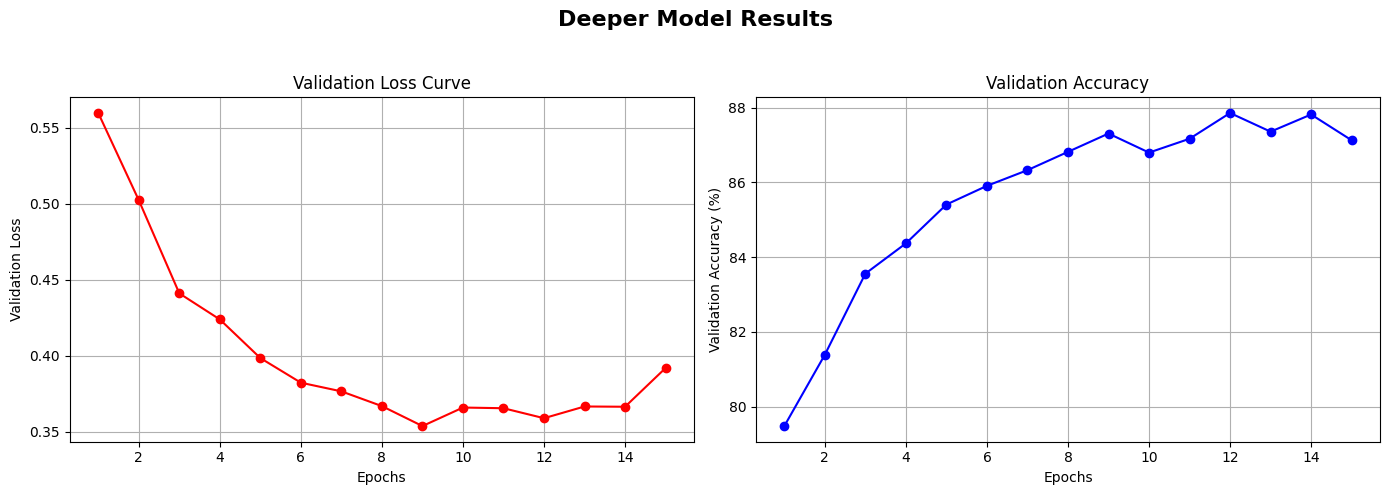

In [14]:
# Display the Loss Curve
display_loss_accuracy("Deeper Model Results", val_loss, val_accuracy, epochs=15)

The base model employed in this experiment uses a standard fully connected architecture with two hidden layers of 512 neurons each, achieving a strong test accuracy of 86% on average. The learning rate was set to 0.1, and the model was trained over 15 epochs. These hyperparameters were chosen based on their ability to provide fast and stable convergence on the relatively simple FashionMNIST dataset, as seen in the discussion above. These parameters also achieve reasonable results while keeping the model training within the hardware constraints of this project. With 669,706 trainable parameters, the base model strikes a healthy balance between model complexity and performance. The validation curves for both loss and accuracy demonstrated reasonably smooth convergence, indicating effective learning.


To explore the impact of model width, the number of neurons in each hidden layer was doubled to 1024, significantly increasing the trainable parameters to 1,863,690. The wider model achieved a higher test accuracy of 87.40%, compared to 86% for the base model, indicating a modest but meaningful improvement. Additionally, the wider model displayed smoother training dynamics. This is evident in the loss decreasing more steadily, and the accuracy increasing with less fluctuation compared to the base model. This suggests that the wider network facilitated better gradient flow and optimisation stability. While the performance gain was not dramatic, it shows that the wider network was able to extract more information from the data, providing a small generalisation benefit on the FashionMNIST dataset.


In contrast, the deeper model introduced two additional hidden layers, resulting in a total of five fully connected layers with 512 neurons each. This increased the parameter count to 830,090, which is more than the base model but still less than the wider one. Surprisingly, this configuration led to a slightly lower test accuracy than the wider model, achieving only 87.40% accuracy on average. The loss curve showed sharper fluctuations, and the accuracy curve was more erratic, indicating less stable convergence during validation. Deeper networks can suffer from issues such as vanishing gradients and optimisation difficulties, particularly when not paired with architectural enhancements like batch normalisation or residual connections. In this case, the added depth may have made it harder for the model to learn effectively, resulting in higher loss and only marginally better performance over the base model.


Overall, the experiments above demonstrate that widening the network can improve the training behaviour and enhance generalisation, while deepening the network makes training more unstable, but can result in performance improvments. These results suggest that for datasets like FashionMNIST, where the classification task is relatively straightforward, increasing model complexity beyond a certain point provides diminishing returns. 

---

<br/>

### **Q1.6 *(2 Points)***

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). **Hint:** The mean of the gradients decrease.

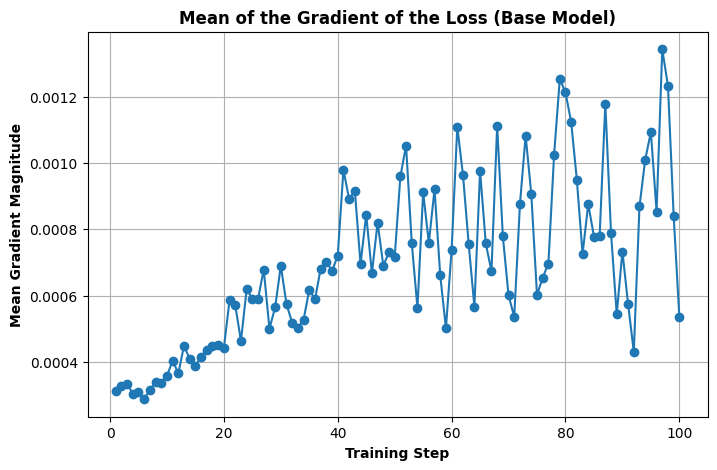

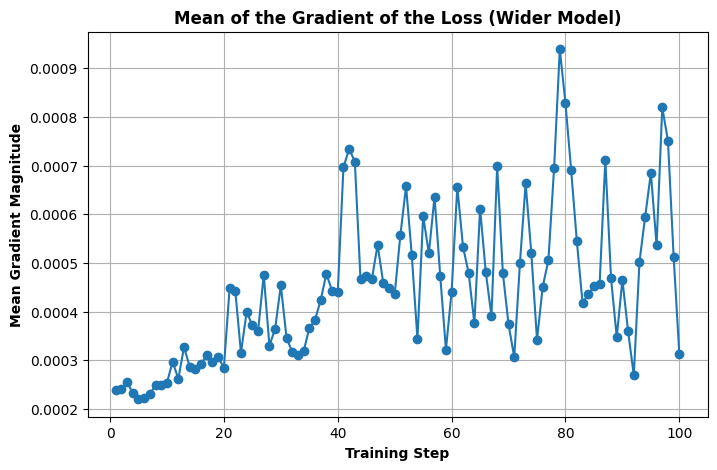

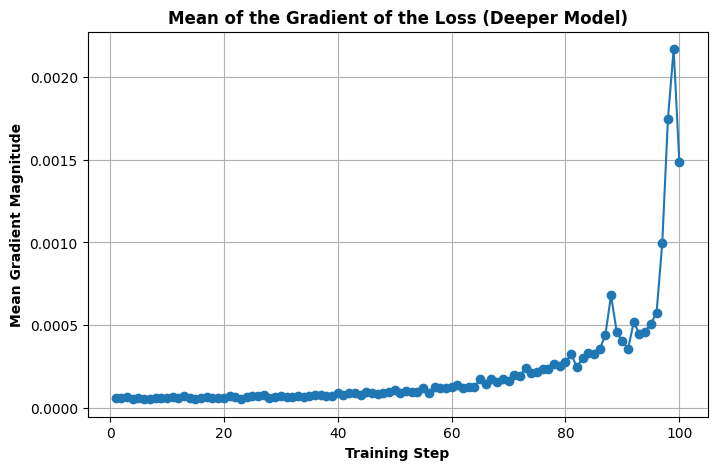

In [15]:
# Dispaly Gradient of the Loss for Base Model
display_loss("Mean of the Gradient of the Loss (Base Model)", "Training Step", "Mean Gradient Magnitude", grad_loss_base[0], epochs = 100)

# Dispaly Gradient of the Loss for Wider Model
display_loss("Mean of the Gradient of the Loss (Wider Model)", "Training Step", "Mean Gradient Magnitude", grad_loss_wide[0], epochs = 100)

# Dispaly Gradient of the Loss for Deeper Model
display_loss("Mean of the Gradient of the Loss (Deeper Model)", "Training Step", "Mean Gradient Magnitude", grad_loss_deep[0], epochs = 100)

After computing and visualising the mean of the gradient of the loss with respect to all trainable parameters over the first 100 training steps, several noteworthy patterns emerge across different architectures. It is important to clarify that the gradient of the loss is not itself a loss value, and therefore it is not necessarily expected to decrease over time. Rather, observing the gradient of the loss helps to understand whether the model is still learning. If the gradients become too small *(vanishing)* or too large *(exploding)*, this could indicate training instability. 


Interestingly, in the first 100 steps of training, the mean of the gradients of the loss often increases rather than decreases, which may seem counterintuitive. This occurs because, during early training, model parameters are still near their random initialisation and have not yet begun to meaningfully reduce the loss. Consequently, gradient magnitudes may grow as the model begins to adjust weights to capture learning signals. 


In the base model *(smallest parameter count)*, gradients exhibit considerable oscillation between ~0.00028 and ~0.0007. This volatility likely stems from the model's limited capacity; each update causes a more pronounced shift in the output, leading to less stable gradient behaviour. In contrast, the wider model *(more neurons per layer)* shows fluctuations within a narrower range *(~0.0002 to ~0.0008)*. The increased number of neurons spreads the learning signal more evenly across parameters, resulting in smaller, more stable gradients. 


The deeper model, with additional hidden layers, starts with low gradient values *(~0.00005)* that steadily rise to ~0.0015. This may reflect early challenges in gradient propagation *(e.g. vanishing gradients)*, followed by a gradual improvement as the model begins learning more abstract representations, assuming appropriate weight initialisation and activations. Overall, these findings show that architecture has a significant impact on early gradient dynamics. Smaller models yield more erratic gradients, wider models benefit from more stable updates, and deeper models require time for gradients to propagate effectively. The key takeaway is that increasing gradients during early training is not inherently problematic; it often reflects the model beginning to learn.


---

<br/>

### **Q1.7 *(5 Points)***

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with regard to convergence, accuracy and number of parameters, relative to MLPs. **Hint:** Look at the structure of the CNN in the Workshop 3 examples.

For more explanation of Q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing.

In [16]:
# Define a Simple Convolutional Neural Network Model
class SimpleConv(nn.Module):
    # Define the New Constructor
    def __init__(self):
        super(SimpleConv, self).__init__() # Call the Constructor of nn.Module
        self.conv1 = nn.Conv2d(1, 16, 3, 1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1, bias=False)
        self.linear = nn.Linear(32*7*7, 20, bias=False)
        self.pool = nn.MaxPool2d(2,2)

    # Define the Forward Pass Function
    def forward(self, x):
        x1 = self.pool(self.conv1(x))  # Now 28x28 → 14x14
        x2 = self.pool(self.conv2(x1)) # 14x14 → 7x7
        x3 = self.linear(x2.view(x2.size(0), -1))
        return x3

# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))

# Use the New Model Above
model = SimpleConv().to(device)

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, _ = train_model(model, train_dataloader, test_dataloader, epochs = 20, lr = 0.1)

Using cpu device
Epoch 1
-------------------------------
loss: 3.013880  [    0/60000]
loss: 0.709016  [ 6400/60000]
loss: 0.438895  [12800/60000]
loss: 0.524177  [19200/60000]
loss: 0.637074  [25600/60000]
loss: 0.583498  [32000/60000]
loss: 0.400161  [38400/60000]
loss: 0.564520  [44800/60000]
loss: 0.621898  [51200/60000]
loss: 0.416306  [57600/60000]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.465096 

Epoch 2
-------------------------------
loss: 0.295238  [    0/60000]
loss: 0.358282  [ 6400/60000]
loss: 0.236367  [12800/60000]


loss: 0.406419  [19200/60000]
loss: 0.392611  [25600/60000]
loss: 0.468792  [32000/60000]
loss: 0.302676  [38400/60000]
loss: 0.513078  [44800/60000]
loss: 0.475525  [51200/60000]
loss: 0.330457  [57600/60000]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.401922 

Epoch 3
-------------------------------
loss: 0.213287  [    0/60000]
loss: 0.314661  [ 6400/60000]
loss: 0.155583  [12800/60000]
loss: 0.355262  [19200/60000]
loss: 0.342905  [25600/60000]
loss: 0.425700  [32000/60000]
loss: 0.259261  [38400/60000]
loss: 0.487675  [44800/60000]
loss: 0.399967  [51200/60000]
loss: 0.291361  [57600/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.374928 

Epoch 4
-------------------------------
loss: 0.180318  [    0/60000]
loss: 0.292517  [ 6400/60000]
loss: 0.128376  [12800/60000]
loss: 0.319161  [19200/60000]
loss: 0.325494  [25600/60000]
loss: 0.391854  [32000/60000]
loss: 0.237928  [38400/60000]
loss: 0.470198  [44800/60000]
loss: 0.352044  [51200/60000]
loss: 0.268851  [57600/60000]
Test E

Trainable parameters: 36112


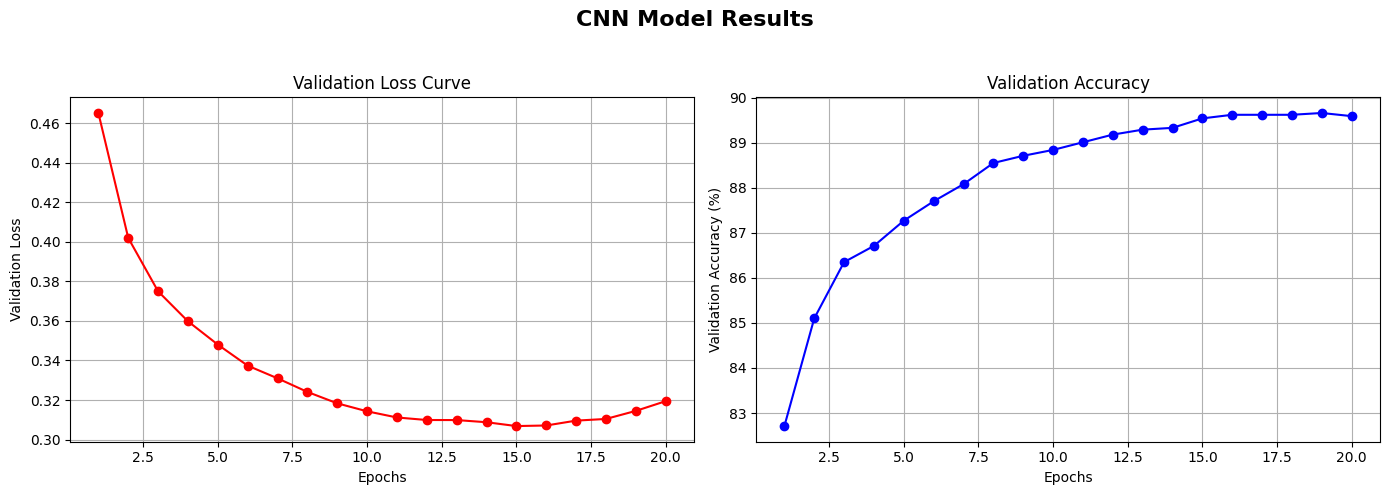

In [17]:
# Count Trainable Parameters
print(f"Trainable parameters: {count_trainable_params(model)}")

# Display the Loss Curve & Accuracy
display_loss_accuracy("CNN Model Results", val_loss, val_accuracy, epochs=20)

After training and analysing Multi-Layer Perceptron (MLP) Models, a simple Convolutional Neural Network (CNN) was built and trained with the same general structure *(3 convolutional layers)* and learning rate *(0.1)* as the MLPs explored above. The results of this show several key differences that can be observed regarding convergence, accuracy, and parameter count.


The CNN model converged in approximately 18 epochs, whereas the best-performing MLP reached convergence in around 15 epochs. This difference in convergence speed can be attributed to the structural differences between the two architectures. Convolutional Neural Networks incorporate inductive biases such as spatial locality and translation invariance, which enable them to learn hierarchical representations of features from image data. However, the inclusion of convolution and pooling operations introduces additional computational steps, which can increase the number of epochs required for the model to stabilise. The additional training epochs likely reflect the time required for convolutional filters to progressively learn low to high-level features across the network's layers.


Despite taking slightly longer to converge, the CNN achieved a higher accuracy of ~90%, compared to the best MLP *(~88%)*. This is expected because CNNs are inherently better at processing spatial data like images. The use of convolutional layers allows the network to learn local patterns *(edges and textures)* and build up to more abstract features in deeper layers. In contrast, MLPs treat all input pixels equally and don't capture spatial relationships, which limits their performance on image classification tasks. This is why CNNs outperform MLPs even with fewer training parameters.


An interesting and important observation is that the CNN had only 36,112 trainable parameters, compared to 669,706 for the smallest MLP, a reduction of about 18.5x. This large difference is due to weight sharing in convolutional layers. In MLPs, every neuron in one layer is connected to every neuron in the next, resulting in a huge number of parameters. In CNNs, each filter is applied across the entire input image, dramatically reducing the number of weights while still allowing the network to extract relevant features. Pooling layers further reduce spatial dimensions, leading to a much more compact and accurate model.


---

<br/><br/>


# **Question 2: Optional Bonus Question  *(5 Marks, 20% Bonus Marks)***
<br/>

### **Q2.1 *(2 Points)***

Experiment with different activation functions (ReLU, Tanh, Sigmoid) and analyse their impact on training performance.

In [16]:
# Define a Simple Convolutional Neural Network Model with Activation Layers
class ConvActivation(nn.Module):
    # Define the New Constructor
    def __init__(self, activation_function):
        super(ConvActivation, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1, bias=True)
        self.linear = nn.Linear(32*7*7, 20, bias=True)
        self.pool = nn.MaxPool2d(2,2)
        self.activation_function = activation_function

    # Define the Forward Pass Function
    def forward(self, x):
        x1 = self.activation_function(self.pool(self.conv1(x)))  # Now 28x28 → 14x14
        x2 = self.activation_function(self.pool(self.conv2(x1))) # 14x14 → 7x7
        x3 = self.linear(x2.view(x2.size(0), -1))
        return x3

In [17]:
# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Use the New Model Above
model = ConvActivation(activation_function=nn.ReLU()).to(device)

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_ReLU = train_model(model, train_dataloader, test_dataloader, epochs = 18, lr = 0.1)

Using cpu device
Epoch 1
-------------------------------
loss: 3.012574  [    0/60000]
loss: 0.846864  [ 6400/60000]
loss: 0.544250  [12800/60000]
loss: 0.626161  [19200/60000]
loss: 0.708799  [25600/60000]
loss: 0.569649  [32000/60000]
loss: 0.430459  [38400/60000]
loss: 0.554119  [44800/60000]
loss: 0.613005  [51200/60000]
loss: 0.423593  [57600/60000]
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.480400 

Epoch 2
-------------------------------
loss: 0.339770  [    0/60000]
loss: 0.376079  [ 6400/60000]
loss: 0.213673  [12800/60000]
loss: 0.457745  [19200/60000]
loss: 0.406166  [25600/60000]
loss: 0.465407  [32000/60000]
loss: 0.307934  [38400/60000]
loss: 0.484712  [44800/60000]
loss: 0.517841  [51200/60000]
loss: 0.350101  [57600/60000]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.395778 

Epoch 3
-------------------------------
loss: 0.266943  [    0/60000]
loss: 0.314016  [ 6400/60000]
loss: 0.147874  [12800/60000]
loss: 0.393912  [19200/60000]
loss: 0.350502  [25600/60000]
loss: 0.4

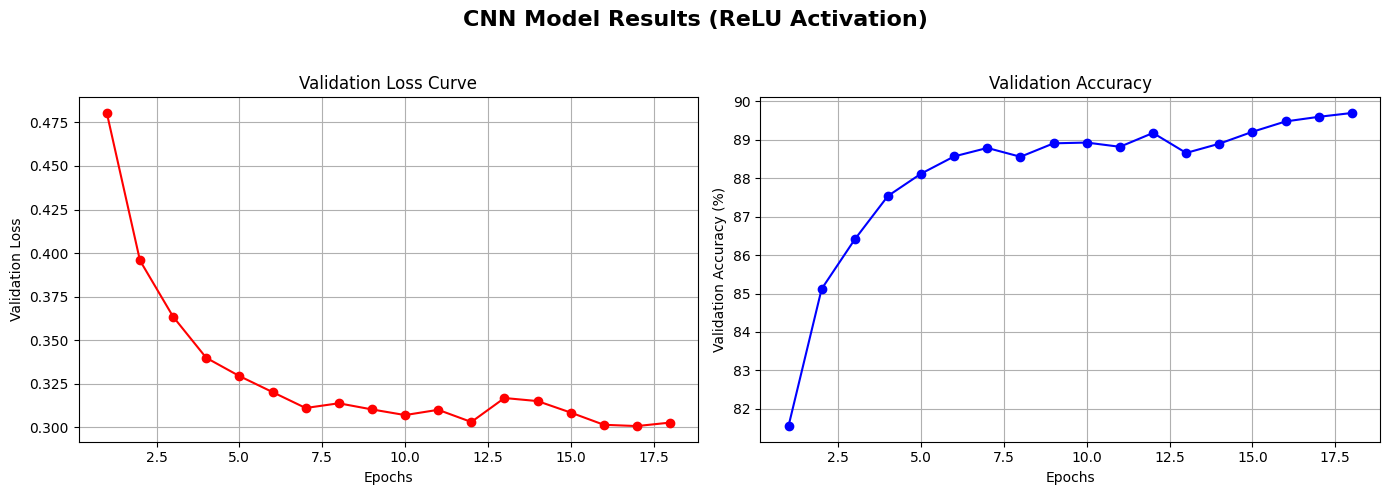

In [18]:
# Display the Loss Curve & Accuracy
display_loss_accuracy("CNN Model Results (ReLU Activation)", val_loss, val_accuracy, epochs=18)

In [19]:
# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Use the New Model Above
model = ConvActivation(activation_function=nn.Tanh()).to(device)

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_tanh = train_model(model, train_dataloader, test_dataloader, epochs = 18, lr = 0.1)

Using cpu device
Epoch 1
-------------------------------
loss: 2.996581  [    0/60000]
loss: 0.712936  [ 6400/60000]
loss: 0.457390  [12800/60000]
loss: 0.588494  [19200/60000]
loss: 0.599149  [25600/60000]


loss: 0.598962  [32000/60000]
loss: 0.403472  [38400/60000]
loss: 0.547939  [44800/60000]
loss: 0.692592  [51200/60000]
loss: 0.405537  [57600/60000]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.456272 

Epoch 2
-------------------------------
loss: 0.284591  [    0/60000]
loss: 0.330442  [ 6400/60000]
loss: 0.262316  [12800/60000]
loss: 0.433786  [19200/60000]
loss: 0.392382  [25600/60000]
loss: 0.507047  [32000/60000]
loss: 0.290854  [38400/60000]
loss: 0.478004  [44800/60000]
loss: 0.560348  [51200/60000]
loss: 0.342041  [57600/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.389999 

Epoch 3
-------------------------------
loss: 0.224406  [    0/60000]
loss: 0.276985  [ 6400/60000]
loss: 0.199778  [12800/60000]
loss: 0.387067  [19200/60000]
loss: 0.343938  [25600/60000]
loss: 0.469684  [32000/60000]
loss: 0.266781  [38400/60000]
loss: 0.431758  [44800/60000]
loss: 0.461646  [51200/60000]
loss: 0.295844  [57600/60000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.357379 

Epoch 4
------

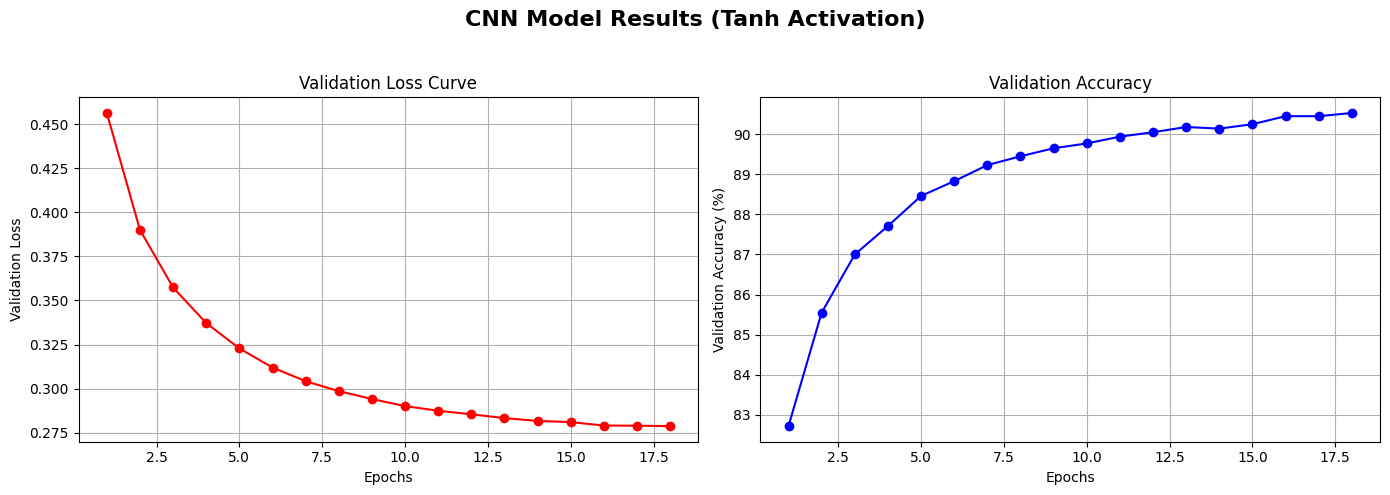

In [20]:
# Display the Loss Curve & Accuracy
display_loss_accuracy("CNN Model Results (Tanh Activation)", val_loss, val_accuracy, epochs=18)

In [21]:
# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Use the New Model Above
model = ConvActivation(activation_function=nn.Sigmoid()).to(device)

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_sigmoid = train_model(model, train_dataloader, test_dataloader, epochs = 18, lr = 0.1)

Using cpu device
Epoch 1
-------------------------------
loss: 3.005118  [    0/60000]
loss: 2.302734  [ 6400/60000]
loss: 1.994712  [12800/60000]
loss: 1.275461  [19200/60000]
loss: 1.042020  [25600/60000]
loss: 0.942083  [32000/60000]
loss: 0.846086  [38400/60000]
loss: 0.827792  [44800/60000]
loss: 0.772112  [51200/60000]
loss: 0.761989  [57600/60000]
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.703468 

Epoch 2
-------------------------------
loss: 0.593261  [    0/60000]
loss: 0.719529  [ 6400/60000]
loss: 0.482313  [12800/60000]
loss: 0.798131  [19200/60000]
loss: 0.759250  [25600/60000]
loss: 0.723945  [32000/60000]
loss: 0.662284  [38400/60000]
loss: 0.699071  [44800/60000]
loss: 0.704561  [51200/60000]
loss: 0.626505  [57600/60000]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.604279 

Epoch 3
-------------------------------
loss: 0.491988  [    0/60000]
loss: 0.602698  [ 6400/60000]
loss: 0.403009  [12800/60000]
loss: 0.659585  [19200/60000]
loss: 0.673333  [25600/60000]
loss: 0.6

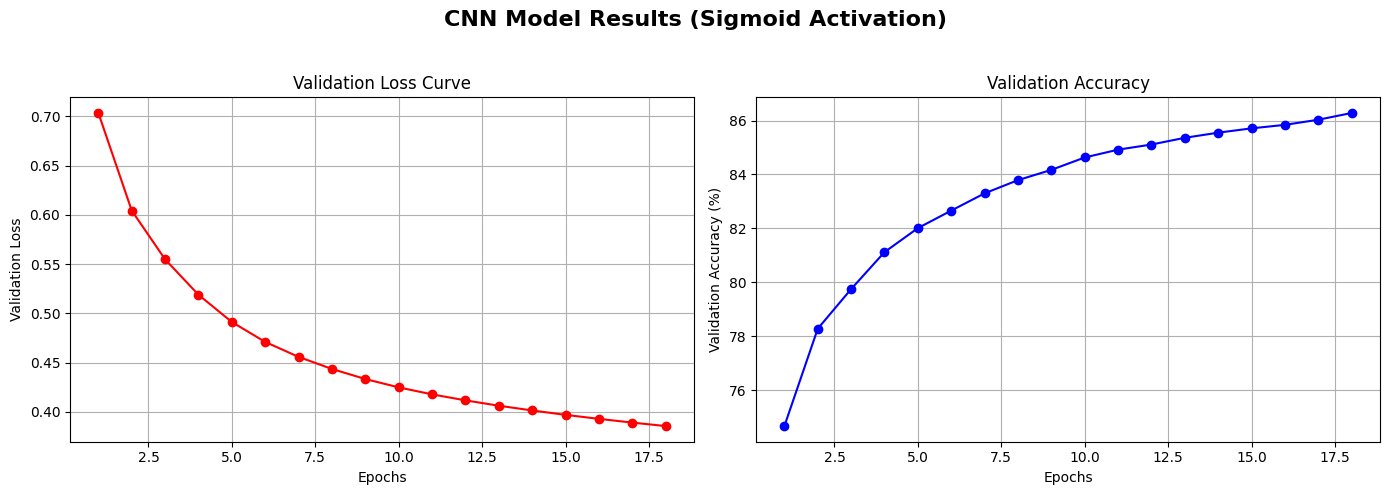

In [22]:
# Display the Loss Curve & Accuracy
display_loss_accuracy("CNN Model Results (Sigmoid Activation)", val_loss, val_accuracy, epochs=18)

To enhance the performance of the convolutional neural network (CNN) used in part 1.7, activation functions were implemented between the convolution and pooling layers. The model now consists of two convolutional layers, each followed by an activation layer and a max-pooling operation, before passing through a fully connected linear layer. This structure was chosen for its balance between model complexity and interpretability, especially given the nature of the dataset. The first convolutional layer captures low-level features such as edges, while the second layer builds on these to detect more abstract patterns. By applying a padding of one in the convolutional layers, the spatial dimensions of the input are preserved, which helps retain information near the borders. Bias terms were included in each layer to increase the flexibility of the learned transformations, and the max-pooling operations serve to reduce the spatial resolution, encourage translational invariance, and decrease computational load.


The inclusion of activation functions is critical, as they introduce non-linearity, allowing the model to learn complex, real-world patterns that a purely linear system could not capture. ReLU (Rectified Linear Unit), Tanh, and Sigmoid functions were each tested to observe their impact on training behaviour and model performance. The training was conducted using a consistent number of epochs and learning rate across all three activation setups *(e.g. 18 epochs with a learning rate of 0.1)*, to ensure a fair comparison.


With ReLU, the model achieved approximately 90% accuracy when validated on the test dataset, a clear improvement over the baseline models used in question 1. Additionally, the validation loss decreased steadily and corrected itself effectively within the first few epochs. This behaviour is typical of ReLU due to its ability to maintain strong gradients and avoid saturation, enabling rapid and stable learning in the early stages.


Interestingly, the model using the Tanh activation function slightly outperformed ReLU, achieving a test accuracy of approximately 91%. The loss curve was very smooth, indicating stable convergence throughout training. While Tanh generally performs best with zero-centred inputs, this result suggests that even without normalising the Fashion-MNIST dataset, Tanh was able to effectively transform the positively skewed input values. This may be due to its non-linearity and ability to output both positive and negative values, which still supports a more balanced gradient flow compared to the Sigmoid activation function. Although ReLU is typically more robust to input scale, in this case, Tanh's smoother gradient across its range appears to have offered a slight advantage in convergence and final accuracy.


In contrast, the Sigmoid activation function led to slower learning and lower overall performance, with the model only reaching around 86% accuracy. The gradient was not as steep during the early epochs, and the model converged more slowly. This is a known limitation of the Sigmoid function, which tends to suffer from vanishing gradients as the output saturates for large input values. While preprocessing operations like Xavier initialisation may help mitigate this by keeping the signal variance stable across layers, the fundamental limitations of Sigmoid in deep networks mean it typically underperforms compared to ReLU or Tanh in this kind of setting.


---

<br/>

### **Q2.2 *(1 Point)***

In particular, focus your analysis on the Sigmoid activation function and discuss your finding of training with and without Xavier initialisation. You may use the provided code for Xavier initialisation for this.

In [23]:
# Define Function to Apply Xavier Initialisation to the Model
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Train & Test the Model Again with the Xavier Initialisation
model = ConvActivation(activation_function=nn.Sigmoid()).to(device)

# Apply the Xavier Initialisation to the Model
model.apply(init_weights)

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_xavier = train_model(model, train_dataloader, test_dataloader, epochs = 18, lr = 0.1)

Using cpu device
Epoch 1
-------------------------------
loss: 3.315628  [    0/60000]
loss: 2.309787  [ 6400/60000]
loss: 2.006918  [12800/60000]
loss: 1.227615  [19200/60000]
loss: 1.020137  [25600/60000]
loss: 0.898584  [32000/60000]
loss: 0.810897  [38400/60000]
loss: 0.799049  [44800/60000]
loss: 0.754778  [51200/60000]
loss: 0.743767  [57600/60000]
Test Error: 
 Accuracy: 75.7%, Avg loss: 0.672577 

Epoch 2
-------------------------------
loss: 0.589206  [    0/60000]
loss: 0.704327  [ 6400/60000]
loss: 0.456409  [12800/60000]
loss: 0.724887  [19200/60000]
loss: 0.693558  [25600/60000]
loss: 0.704157  [32000/60000]
loss: 0.637435  [38400/60000]
loss: 0.680573  [44800/60000]
loss: 0.694862  [51200/60000]
loss: 0.611213  [57600/60000]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.586485 

Epoch 3
-------------------------------
loss: 0.491942  [    0/60000]
loss: 0.584780  [ 6400/60000]
loss: 0.380906  [12800/60000]
loss: 0.621243  [19200/60000]
loss: 0.618851  [25600/60000]
loss: 0.6

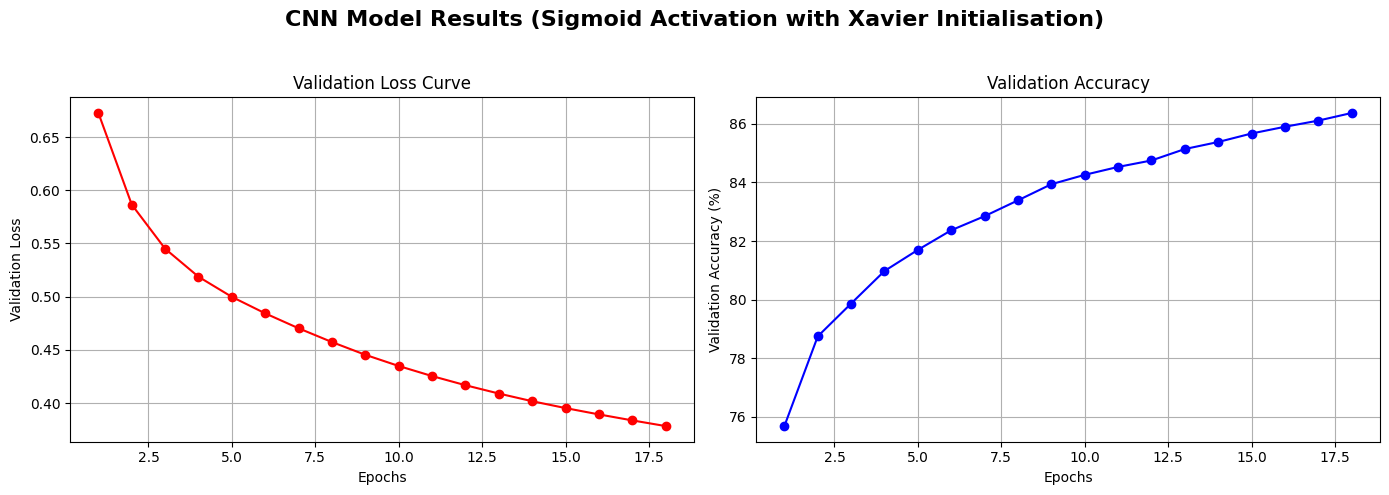

In [24]:
# Display the Loss Curve & Accuracy
display_loss_accuracy("CNN Model Results (Sigmoid Activation with Xavier Initialisation)", val_loss, val_accuracy, epochs=18)

When using the Sigmoid activation function without any special weight initialisation, the model exhibited slow convergence and achieved a lower final accuracy *(approximately 86%)* compared to models using ReLU or Tanh. This is expected behaviour, as Sigmoid activations are known to suffer from vanishing gradients, especially when deeper in the network or when weights are poorly scaled. To try and improve the results for the Sigmoid Function, Xavier initialisation was applied in an attempt to mitigate this issue. 


Theoretically, Xavier initialisation helps maintain stable gradients throughout training by scaling the initial weights based on the number of input and output connections, a method that works particularly well with symmetric activation functions like Sigmoid. However, in practice, the model using Sigmoid activation layers with Xavier initialisation actually performed about the same, achieving an accuracy of approximately 86%. One likely explanation is that the Fashion-MNIST dataset is relatively simple, and the network is shallow, so the benefits of careful weight scaling are less pronounced. In such cases, small variations due to weight initialisation may have a minor impact, and training instability due to suboptimal initialisation is unlikely to manifest significantly. Another possibility is that Sigmoid’s intrinsic limitations *(such as saturation at extremes)* still hinder its learning dynamics, even with better-initialised weights.


---

<br/>

### **Q2.3 *(1 Point)***

Additionally, plot both the gradient and loss curves for your experiments. For gradient analysis, you may select one representative layer to monitor throughout training and briefly explain your choice.

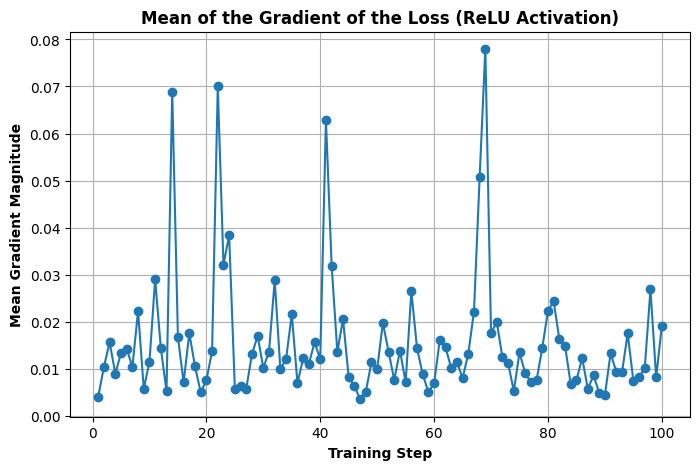

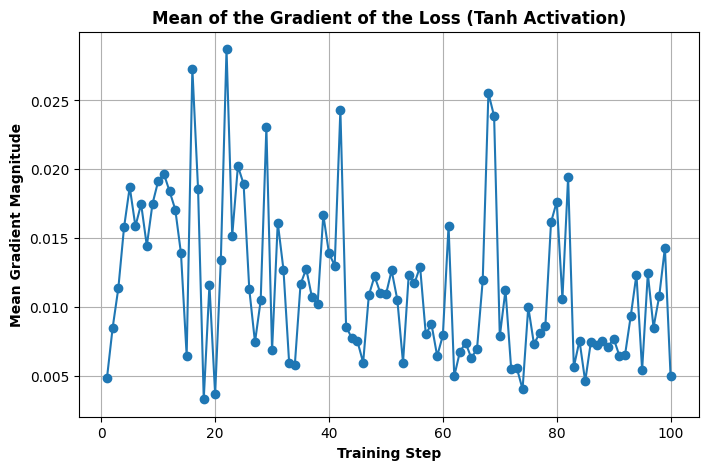

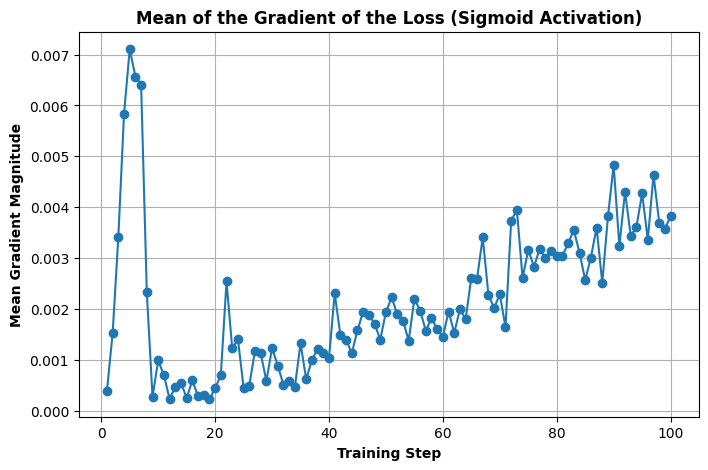

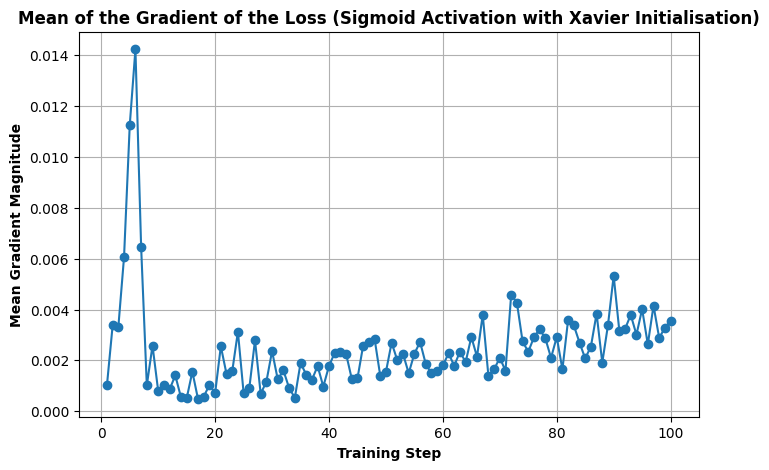

In [ ]:
# Dispaly Gradient Loss for ReLU Activation Layer
display_loss("Mean of the Gradient of the Loss (ReLU Activation)", "Training Step", "Mean Gradient Magnitude", grad_loss_ReLU[0], epochs = len(grad_loss_ReLU[0]))

# Dispaly Gradient Loss for Tanh Activation Layer
display_loss("Mean of the Gradient of the Loss (Tanh Activation)", "Training Step", "Mean Gradient Magnitude", grad_loss_tanh[0], epochs = len(grad_loss_tanh[0]))

# Dispaly Gradient Loss for Sigmoid Activation Layer
display_loss("Mean of the Gradient of the Loss (Sigmoid Activation)", "Training Step", "Mean Gradient Magnitude", grad_loss_sigmoid[0], epochs = len(grad_loss_sigmoid[0]))

# Dispaly Gradient Loss forReLU Activation Layer with Xavier Initialisation
display_loss("Mean of the Gradient of the Loss (Sigmoid Activation with Xavier Initialisation)", "Training Step", "Mean Gradient Magnitude", grad_loss_xavier[0], epochs = len(grad_loss_xavier[0]))

For this analysis, the first convolutional layer (`conv1`) was selected as the representative layer for monitoring gradients. This layer was chosen because it is directly impacted by the activation function and is close to the input. As a result, it provides a clear view of how well gradients are able to propagate backwards through the network. If vanishing gradients occur due to poor activation or initialisation, they are most likely to show up clearly in the earliest layers.


In the case of the **ReLU** activation function, the gradient values fluctuated within a moderate range *(approximately 0.005 to 0.03)*, with occasional sharp spikes reaching up to around 0.07. These spikes likely correspond to specific batches with more active neurons or large errors, causing stronger updates. ReLU is known for sparse activation, so neurons can *"die"* if they receive no gradient, but when active, they propagate strong gradients, which explains the sharp but infrequent spikes.


The **Tanh** activation showed smoother, less noisy gradient curves, typically oscillating between ~0.005 and ~0.02, with rare spikes reaching around 0.035. Tanh maintains a more consistent gradient due to its continuous and symmetric shape, resulting in more stable updates. Its zero-centred nature supports better gradient flow, which is why its gradient curve is more stable and controlled compared to ReLU.


The **Sigmoid** function demonstrated a very different pattern. It showed a large spike in the first few epochs *(from ~0.0002 to ~0.009)*, followed by a slower, steady increase in gradient values, eventually plateauing near 0.005. This initial spike likely represents the network's attempt to push activations out of the saturated regions of the sigmoid function where gradients vanish. As training progresses, the gradients improve slightly, but their small scale overall suggests the model is still struggling to update weights effectively, contributing to slower learning and lower accuracy.


When **Xavier initialisation** was applied to the model with the Sigmoid activation, the initial gradient spike remained, but the overall gradient curve was less steep and more controlled. The gradients increased to around 0.010 early on but eventually decreased and stabilised around 0.003. This behaviour suggests that Xavier initialisation helped prevent exploding gradients, but it may have also dampened the model’s ability to make strong corrections in the early epochs. This reduced aggressiveness in learning could explain why the sigmoid model with Xavier performed slightly worse than the one without it. In this case, the gradients were too cautious to recover quickly from the initial poor weight regions.


---

<br/>

### **Q2.4 *(1 Point)***

**Discuss how gradients and loss behave across the network for different activation functions and initialisation methods if you see any difference.**

Across all experiments, the behaviour of gradients and loss during training varied notably with the choice of activation function and weight initialisation. ReLU produced strong, fluctuating gradients that enabled fast convergence and high accuracy, although its *“spiky”* pattern reflects its sparse activation nature. Tanh led to smoother, more stable gradients and slightly better performance, likely due to its symmetric and zero-centred output that supports more consistent learning dynamics. In contrast, Sigmoid exhibited vanishing gradients, especially early in training, leading to slower convergence and reduced accuracy. While Xavier initialisation partially mitigated this by stabilising weight scaling and tempering the gradient explosion risk, it ultimately did not fully overcome the intrinsic limitations of Sigmoid in deeper networks. These observations highlight the critical interplay between activation functions and initialisation strategies in maintaining effective gradient flow, ensuring fast convergence, and maximising model performance.

---

<br/><br/>
## **Question 3: Proposal for Practical Applications *(40%)***

In this part of the assignment you need to write a report about an application of a computer vision algorithm or technique. This can either be an application that you are aware of and possibly even use, such as a phone app, or it could be speculation -- an application that you think would benefit from using computer vision.

**Begin by choosing a particular CV idea, method or problem area, such as:**

**a.** Removing noise in an image.

**b.** Increasing the resolution of an image.

**c.** Detecting and/or identifying objects in an image.

**d.** Segmenting images into constituents parts.

**e.** Estimating the depth of an object from one or more images.

**f.** Estimating the motion of two objects in different frames.

**g.** Others
<br/><br/>


Now think about various ways your chosen technique could be used. Here is a list of possible applications you could consider, but you are not restricted to this list, and there will be credit given for sensible invention outside this list (but no penalty if you don't want to be "inventive"): image editing systems in your phone; enhancement of images from old film; obstacle detection and avoidance for a domestic robot; facial recognition for phone security; cancer detection; person tracking and re-identification in security cameras; sport decision review systems; road-sign detection and interpretation for self-driving cars.
<br/>

This is a little bit back-to-front from what might happen in real life in which the application usually motivates the solution, but the emphasis here is on an understanding of the CV technique.
<br/><br/>


**You need to write a short report *(800 words max)* in which you do the following:**

**1.** Clearly define the CV problem/area and describe its application scenarios.

**2.** Briefly describe a solution based on image processing, computer vision and/or machine learning.

**3.** Discuss the advantages and the limitations of this method in various application scenarios.

**4.** It is important that you will define a useful metric to evaluate the performance of your method and discuss its tradeoff specific to the problem you have chosen.

**5.** You are welcome to cite existing work and take inspiration form literature addressing the problem you choose.
<br/><br/>


**For Q3, you do not need to implement your solution. Just write the proposal/report and submit it as a separate PDF.**

- **Hint 1:** Submit an individual pdf report for question 3.

- **Hint 2:** Organise your report well.

- **Hint 3:** You can use diagrams, flow charts or other figures in your report for better understanding of your solution.  

